# Logistic regression I: MNIST

In this notebook, you will implement a logistic regression and train it to distinguish between two types of digits of the MNIST dataset.

First, the standard imports:

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import torch as th
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from sklearn import metrics

plt.rcParams["figure.figsize"] = (9, 6)

## Dataset loading

We will use the MNIST dataset available in `torchvision`:

In [2]:
mnist_train = MNIST("./datasets", train=True, download=True)
mnist_test = MNIST("./datasets", train=False)

The training dataset is made of 60k images of $28\times{}28$ pixels. The test set contains 10k images.

In [3]:
mnist_train.data.shape, mnist_test.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

As we did in the previous assignment, we vectorize all the images (concatenating their pixels in a sigle row) and consider that they are elements of the Euclidean space $\mathbb{R}^{784}$. Also, we extract their target values.

In [4]:
data_train = th.reshape(mnist_train.data, (-1, 28**2))
data_test = th.reshape(mnist_test.data, (-1, 28**2))

target_train = mnist_train.targets
target_test = mnist_test.targets

print(data_train.shape, data_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


## Data preprocessing

As we saw in the first week, in classical computer vision problems it was necessary to compute relevant features from the images before feeding them to a machine learning model. This had two main goals: first, to reduce the dimensionality of the input space to prevent the _curse of dimensionality_; second, to reduce the variance of the model by making it robust to fluctuations of the input data that are not related to the variable of interest (for example, noise). For the MNIST dataset we could extract features such as the width of the digit, the proportion of white pixels in the image, the distribution of vertical/horizontal/diagonal segments or the number of black connected components (i.e., the number of holes of the digit). As we saw, the downside of feature extraction is that it is problem-dependent and requires a considerable amount of human effort.

Instead of designing a method for feature extraction, in this assignment we will follow the modern deep learning approach and feed the logistic classifier with raw pixel values (logistic regression is a simple neural network, after all). However, as we saw in class, this is not completely straighforward: the gradients of logistic regression are very small when the weights and the input values are not scaled properly, leading to extremely slow training progression. Therefore, you should ensure that the pixel values you will feed to the classifier have an appropriate range, avoiding very large values.

### <font color='orange'>Question 1</font>

Check the range of the image data and rescale it to the range (0, 1) if it is necessary. Apply the same transformation to both the training and test data. Save the results in the variables `data_train` and `data_test`.

There are several options to do this: you can divide by the largest value allowed by the data type of the datasets (the easiest approach), or you can divide by the largest value that is present in the training dataset.

Note that if your transformation depends on a value computed over a dataset (for example, the maximum value of the dataset), you MUST compute that value using only the training dataset. Otherwise, you might be leaking information from the test set to the training procedure.

In [5]:
data_train = data_train / 255
data_test  = data_test / 255

print(f"Min: {data_train.min()}, Max: {data_train.max()}")

Min: 0.0, Max: 1.0


___

### <font color='orange'>Question 2</font>

Logistic regression is a binary classifier, but MNIST has 10 classes. We will follow a one-vs-rest approach and build a model that distinguishes one digit vs. the rest. Pick one digit and set it to the variables `class1`. This digit will get the label 1, while the rest of digits will get the label 0.

Build the target variables `target01_train` and `target01_test` with binary values 1 and 0 indicating whether the corresponding digit is `class1` or not. That is, `target01_train` should be 1 where `target_train` is `class1`, and `data_train[target01_train == 1]` should return all the samples of the `class1`.

Visualize a few samples of each class (you can use `torchvision.utils.make_grid` for this, or plot the samples manually). Show at least 9 samples with `target01_train==0` and 9 samples with `target01_train==1`. Note that you will need `torch.reshape` and perhaps `torch.permute` to provide `plt.imshow` a proper shape it can work with.

In [6]:
class1 = 0  # Change this to the digit you want to use as class 1. The rest of the digits will be class 0.
#target01_train = th.where(target_train == class1, th.ones(target_train.shape), th.zeros(target_train.shape))
target01_train = (target_train == class1).int()
print(target01_train)
# Create the target variables target01_train and target01_test according to the value of class1.
#print(target_train[:20])
#print(target01_train[:20])


tensor([0, 1, 0,  ..., 0, 0, 0], dtype=torch.int32)


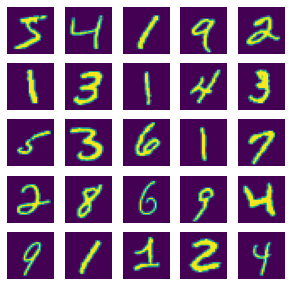

In [7]:
# Plot some samples of class 0
w, h = 5, 5
fig = plt.figure(figsize=(w,h))
for i in range(w*h):
    fig.add_subplot(w,h,i+1)
    plt.imshow(mnist_train.data[~(target01_train).bool()][i])
    plt.axis("off")
    
plt.show()

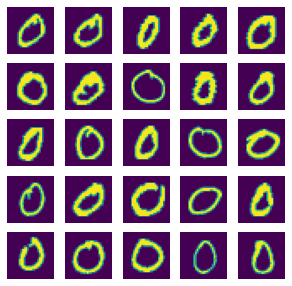

In [8]:
# Plot some samples of class 1
w, h = 5, 5
fig = plt.figure(figsize=(w,h))
for i in range(w*h):
    fig.add_subplot(w,h,i+1)
    plt.imshow(mnist_train.data[target01_train.bool()][i])
    plt.axis("off")
plt.show()

In [51]:
def plot_img(images, w, h, title=None):
    fig = plt.figure(figsize=(w,h))
    if title:
        plt.title(title)
    for i in range(w*h):
        fig.add_subplot(w,h,i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

___

## Logistic regression

Remember that logistic regression consists of a linear (actually, affine) transformation of the input vector `x` with the weights `w` and a bias `b`, followed by the logistic function that shrinks the output range to the range (0, 1),
$$f(\mathbf{x};\mathbf{w}, b) = \sigma(\mathbf{x}^T\cdot\mathbf{w} + b).$$

This equation is expressed for a single input sample $\mathbf{x}$, but in practical implementatios with PyTorch it is necessary that our models are able to process multiple elements simultaneously using tensor operations. The goal of the next exercise is to implement the logistic regression model in such a way that it can deal simultaneously with many input samples, and not just with one.

### <font color='orange'>Question 3</font>

Implement a function `logistic_regression` that receives an input tensor `x` with shape `(num_samples, num_dims)`, a tensor `weights` with shape `(num_dims,)`, a scalar tensor `bias`, and returns the output of the logistic regression with shape `(num_samples,)` for all the elements of `x`.

Hint: use the `@` operator to deal with `x` and `weights`.

Hint: you can use `torch.sigmoid` to apply the logistic function or you can implement it manually.


In [10]:
def logistic_regression(x: th.Tensor, weights: th.Tensor, bias: th.Tensor) -> th.Tensor:
    return th.sigmoid(weights @ x.T + bias)
    #x @ weights.T?

___

As we discussed in class, the output of the logistic regression is interpreted as the probability parameter $\hat{p}=f(\mathbf{x};\mathbf{w}, b)$ of a Bernoulli distribution:
$$p(y\mid \hat{p})=\cases{1-\hat{p} & if y=0\\ \hat{p} & if y=1}.$$

The cross-entropy loss is the $-\log$ of the probability of the correct answer:
$$ \ell(y, \hat{p}) = -\log p(y\mid \hat{p}) = \cases{-\log 1-\hat{p} & if y=0\\ -\log \hat{p} & if y=1}.$$

As above, the implementation of the loss function needs to deal with multiple elements simultaneously for efficiency.

### <font color='orange'>Question 4</font>

Implement the function `binary_cross_entropy` that receives the tensor `p_hat` of shape `(num_samples,)` and type `float` containing the predictions from the logistic regression, and the tensor `y` of the same shape and type `int` containing the correct answer for each element, and computes the **mean** of the cross-entropy losses across all the elements.

Hint: use `torch.where` to select between $-\log \hat{p}$ and $-\log (1-\hat{p})$ according to `y`.

In [11]:
def binary_cross_entropy(p_hat: th.Tensor, y: th.Tensor) -> th.Tensor:
    return th.mean( th.where(y==1, -th.log(p_hat), -th.log(1-p_hat)) )

___

## Training with gradient descent

### <font color='orange'>Question 5</font>

Write code to minimize the loss
$$\min_{\mathbf{w}, b} \sum_i \ell(y^{(i)}, f(\mathbf{x}^{(i)}; \mathbf{w}, b))$$
using gradient descent. The training set should be `data_train` with the labels `target01_train` that you created in Question 2.

This code should

1. Create the tensors of weights and bias with the proper shapes. The initialization of parameters is not a simple topic and we will look at it in more depth in a future class. For now, initializate the weights with random Gaussian values (use `torch.randn`) divided by the number of dimensions (i.e., `th.randn(...) / 784`), and initialize the bias to 0.
2. Enable the gradient computation for these two tensors calling `.requires_grad_()`.
3. Set a learning rate $\eta$.
4. Initialize an empty list `losses` to store intermediate losses and plot them later.
5. Repeat `num_iterations` times:
    1. Compute the loss for the entire training data.
    2. Compute the gradients calling `.backward()` in the loss tensor.
    3. Update the weights and the bias with the computed gradients using the gradient descent update rule. Remember to do so in a `torch.no_grad()` context and set the gradients `.grad` to `None` after the update.
    4. Store the loss into `losses`. Remember to call `.detach()` to store just the value of the tensor and not the computational graph.
    5. You might want to set a stopping criterion that ends training when the changes to the training loss are below a threshold (e.g., `th.abs(losses[-1] - losses[-2]) < 1e-8`), but this is optional.
6. Plot `losses` and check whether/how the training loss decreased during training.

You might need to try a few values for the learning rate $\eta$ and the number of iterations so that the evolution of the training loss looks smooth and converges to an almost constant value. Changes to the learning rate are significant in a logarithmic scale (e.g., $10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}, 10^0, \ldots$), not in a linear scale (e.g., $0.1, 0.2, 0.3, \ldots$). When searching for a good learning rate use a logarithmic scale.

In [12]:
def train_mnist(eta, num_iterations):
    weights = th.randn( 1,784 ) / 784
    weights.requires_grad_()
    bias    = th.tensor(0.0, requires_grad=True)
    losses  = list()

    #pred = logistic_regression(data_train, weights, bias)
    for i in range(num_iterations):
        pred = logistic_regression(data_train, weights, bias)
        loss = binary_cross_entropy(pred, target01_train)
        loss.backward()

        losses.append(loss.detach())

        with th.no_grad():
            weights[...] = weights - weights.grad*eta
            weights.grad = None
            bias[...]    = bias - bias.grad*eta
            bias.grad    = None

        if i>1:
            if th.abs(losses[-1]-losses[-2]) < 1e-8:
                print("Stop criterion reached")
                break

    return losses, weights, bias
    plt.plot(th.arange(num_iterations), losses)

In [13]:
def plot_loss(l):
    plt.plot(th.arange(len(losses)), losses)

In [14]:
#losses, weights, bias = train_mnist(0.1,100)
#plt.plot(th.arange(len(losses)), losses)

perfs = list()
for i in range(2,5):
    for j in range(0,-5,-1):
        nmb = int(10**i)
        eta = 10**j
        l, _, _ =train_mnist(eta, nmb)
        print(f"eta={eta}, iterations={nmb} -> loss: {l[-1]}")
        perfs.append( ( (eta, nmb), l[-1] ) )



eta=1, iterations=100 -> loss: 0.04135838896036148
eta=0.1, iterations=100 -> loss: 0.08234389871358871
eta=0.01, iterations=100 -> loss: 0.22127902507781982
eta=0.001, iterations=100 -> loss: 0.4294964075088501
eta=0.0001, iterations=100 -> loss: 0.6416846513748169
eta=1, iterations=1000 -> loss: 0.02744903601706028
eta=0.1, iterations=1000 -> loss: 0.041299525648355484
eta=0.01, iterations=1000 -> loss: 0.0822821781039238
eta=0.001, iterations=1000 -> loss: 0.22101575136184692


KeyboardInterrupt: 

In [15]:
losses, weights, bias = train_mnist(0.1, 5000)
print(losses[-1])
plot_loss(losses)

KeyboardInterrupt: 

___

### <font color='orange'>Question 6</font>

Answer a few questions regarding the training.

1. Every time training starts, the weights are sampled randomly from a Gaussian distribution and therefore the initial behaviour of the logistic regression is random. Run the training procedure a few times and check the initial value of the loss before any parameter update (use `print` or check `losses[0]` after training). Is this value consistent across initializations? What is this value approximately? Can you guess why?
2. What is the minimum possible value for the cross-entropy loss in theory? What is the minimum value you got in practice? Do you think this is a good value for the training loss?
3. What is the best combination of learning rate and number of iterations that you found?
4. What happens to the training loss if you choose a very high learning rate (for example, 100)? Why?


> Write your solution here. Use several markdown cells if necessary.

In [ ]:
#1

l0 = list()

for _ in range(1000):
    l, _, _ = train_mnist(0.1,1)
    l0.append(l[0])

hist = th.histc(th.tensor(l0), bins=10)
x = range(10)
plt.bar(x, hist)
print(f"Mean: {th.mean(th.tensor(l0))}")

Mean: 0.6930459141731262


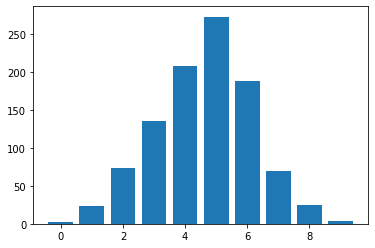

In [ ]:
# 2
print(f"The smallest loss was {min(losses)}")

## 1
The value is around 0.69

## 2

## 3
Learning rate 0.1 and number of iterations 5000

## 4

___

### <font color='orange'>Question 7</font>

Save the weight and the bias after training the best model you got. We will use that model in the next section for evaluation.

**INCLUDE THIS FILE IN THE FINAL SUBMISSION FILE** so I can run the evaluation with your model.

In [ ]:
# Just run this code
th.save({"weights": weights.detach(), "bias": bias.detach()}, "best_model.pt")

___

## Model evaluation

Evaluation of the model with the test dataset.

First, load the parameters of the model:


In [16]:
model = th.load("best_model.pt")
weights = model["weights"]
bias = model["bias"]

### <font color='orange'>Question 8</font>

Apply the loaded logistic model to the test dataset `data_test` and measure its performance with the labels `target01_test` that you created in Question 2.

1. Plot the ROC curve and the precision-recall curve (make some _nice_ and _decent_ plots with a grid, properly labelled axes...).
2. Compute the area under the ROC curve and the average precision (i.e., the area under the precision-recall curve).
3. Choose a good threshold for the model output and compute the accuracy, sensitivity, specificity, precision, and recall for that threshold.
4. Analyze the results. According to these results, does the model perform well in this problem?

You can use functions from `sklearn.metrics`. Check [the documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

Found optimal threshold at: 0.20711329579353333


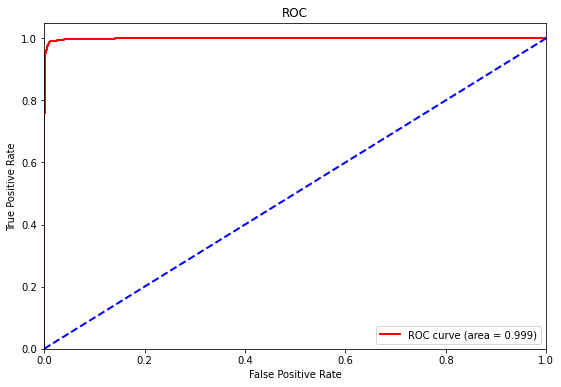

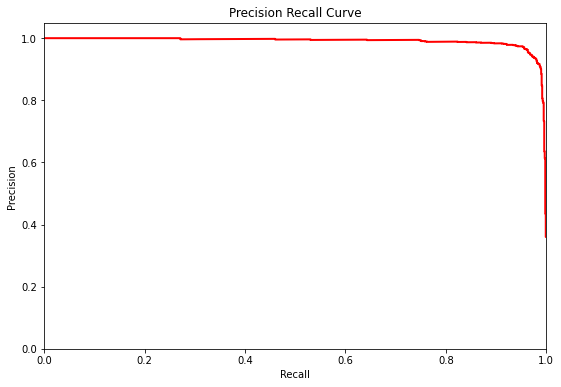

TP: 980, FP: 0
FN: 106, TN: 8040
Accuracy: 98.83000183105469%
Sensitiviy: 0.9023941159248352
Specificity 1.0
Precision [Class0 Class1]: [0.99876751 0.90139535]
Recall [Class0 Class1]: [0.98824834 0.98877551]


In [32]:
pred = logistic_regression(data_test, weights, bias)
pred = th.flatten(pred)

hist = th.histc(pred, bins=10)
x = range(10)
#plt.bar(x, hist)

#plot_img(mnist_test.data[pred.bool()], 5, 5)

target01_test = (target_test == class1).int()

#target01_test[target01_test.bool()] == target_test[target01_test.bool()])

#--ROC------------------------------------------------------------------------------
fpr, tpr, thresholds = metrics.roc_curve(target01_test, pred)
auc = round(metrics.auc(fpr, tpr), 3)

optimal_threshold = thresholds[np.argmax(tpr-fpr)]
print(f"Found optimal threshold at: {optimal_threshold}")

plt.figure()
plt.plot(
    fpr,
    tpr,
    color="red",
    lw=2,
    label=f"ROC curve (area = {auc})"
)
plt.plot([0 ,1],[0 ,1], color="blue", lw=2, linestyle="--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

#--Precision Recall------------------------------------------------------------------
precision, recall, thresholds2 = metrics.precision_recall_curve(target01_test, pred)

plt.figure()
plt.plot(
    recall,
    precision,
    color="red",
    lw=2,
    label=f"Precision Recall Curve"
)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Curve")
plt.show()


pred_bin = th.where(pred>optimal_threshold, th.ones(pred.shape), th.zeros(pred.shape))
correct  = th.count_nonzero(target01_test == pred_bin)

TP = th.count_nonzero(pred[target01_test.bool()])
FP = pred_bin[target01_test.bool()].shape[0] - TP

FN = th.count_nonzero(pred_bin[~target01_test.bool()])
TN = pred_bin[~target01_test.bool()].shape[0] - TP

TPR = TP / (TP + FN)
FPR = FP / (FP + TN)

print(f"TP: {TP}, FP: {FP}")
print(f"FN: {FN}, TN: {TN}")

accuracy    = correct/pred.shape[0]*100
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision, recall, _, _ = metrics.precision_recall_fscore_support(target01_test, pred_bin)
print(f"Accuracy: {accuracy}%")
print(f"Sensitiviy: {sensitivity}\nSpecificity {specificity}")
print(f"Precision [Class0 Class1]: {precision}\nRecall [Class0 Class1]: {recall}")



#### 8.4
The accuracy of almost 99% seems quite decent. I guess for such a relatively simple problem there is some potential to increase the performance further but I'm quite content.

___

### <font color='orange'>Question 9</font>

Explore and plot hard cases. Find the samples of the test set that were the most difficult for the model (i.e., high probability of class 1 for samples that are class 0 and vice versa). What are the probabilities that the model predicted for these difficult cases? Plot at least 9 difficult cases from class 0 and 9 difficult cases from class 1.

Explain why you think those cases were hard.

Hint: you can use `torchvision.utils.make_grid` to make plotting easier.

torch.Size([9])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)
tensor([0.0032, 0.0059, 0.0206, 0.0237, 0.0483, 0.0761, 0.0821, 0.0895, 0.1252])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])


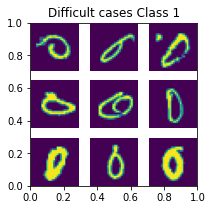

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32)
tensor([0.9442, 0.9458, 0.9485, 0.9488, 0.9498, 0.9729, 0.9858, 0.9907, 0.9968])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])


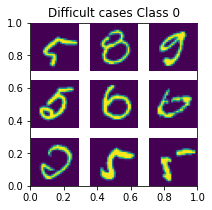

In [111]:
#difficult1 = th.argsort(th.where(pred>optimal_threshold, pred, th.ones(pred.shape)))[:9]
difficult0 = th.argsort(th.where(pred<=optimal_threshold, pred, th.zeros(pred.shape)))[-9:]
#difficult1 = th.argsort(pred[target01_test.bool()])[:9]
difficult1 = th.argsort(th.where(target01_test.bool(), pred, th.ones(pred.shape)))[:9]
print(difficult1.shape)

difficult0 = th.argsort(th.where(~(target01_test.bool()), pred, th.zeros(pred.shape)))[-9:]

print(target01_test[difficult1])
print(pred[difficult1])
print(pred_bin[difficult1])
plot_img(mnist_test.data[difficult1], 3, 3, "Difficult cases Class 1")

print(target01_test[difficult0])
print(pred[difficult0])
print(pred_bin[difficult0])
plot_img(mnist_test.data[difficult0], 3, 3, "Difficult cases Class 0")


___

### Model analysis

### <font color='orange'>Question 10</font>

Plot the weights of the model as a $28\times{}28$ image with `plt.imshow`. Add a colorbar with `plt.colorbar` to show the range of weights and which weights are positive or negative.

Can you explain this result? Do these weights make sense for the `class1` that you chose?

Hint: think of the effect that an active pixel has on the output of the logistic regression when the weight corresponding to that pixel is positive/negative. 

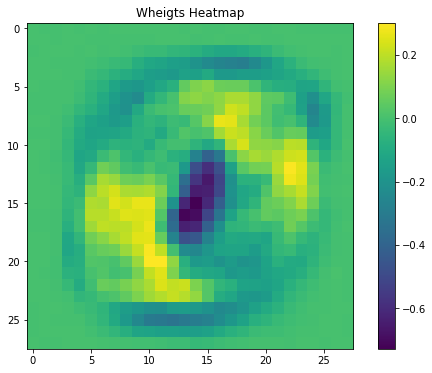

In [125]:
weights.shape
w = th.reshape(weights, (28, 28))
fig, ax = plt.subplots()
ax.set_title("Wheigts Heatmap")
pos = ax.imshow(w)
_ = fig.colorbar(pos, ax=ax)

The weights seems to make sense. Interestinlgy it seems to penalize very strongly against pixels in the middle of the zero. It does make sense, as this region is likely occupied by all other digits. The system would maybe run into problems, when people write the zero with the / trough the middle. Also notable is, that the system seems to expect a slightly right skewed shape, as lines in the right upper and lower right corner seem to be insentivised. Around of the whole circle of mostly positive values is a small border of negative values. I think this probably acts like an edge detection filter.